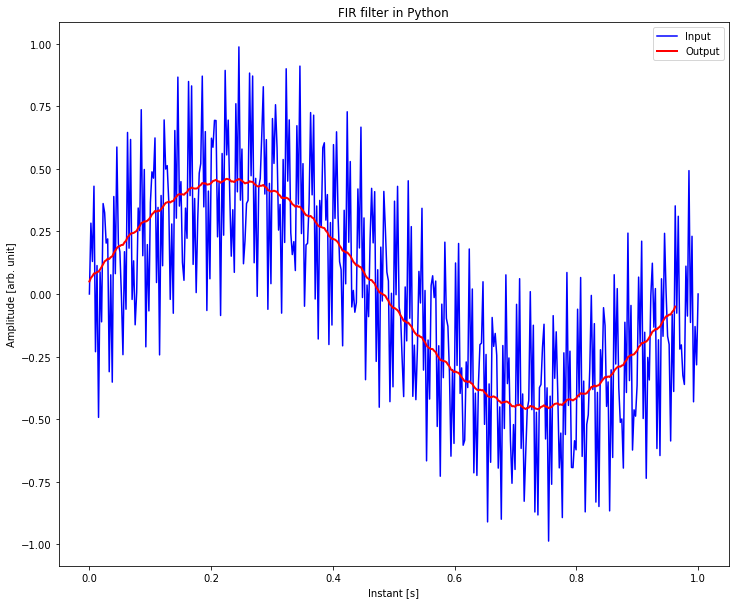

In [25]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

#Lowpass filter with cutoff @3Hz and 16 taps
numtaps = 16
coefficients = signal.firwin(numtaps, 3, pass_zero='lowpass', fs = 400)

#400 samples/s
xs = np.linspace(0, 1, 400)

def sinusoidal_wave(xs, f):
    return np.sin(2 * np.pi * f * xs)

#Input signal as superposition of 3 sinusoidal waves with different frequencies
amplitudes = np.array([5, 3, 3])
waves = np.array([sinusoidal_wave(xs, 1), sinusoidal_wave(xs, 50), sinusoidal_wave(xs, 180)])
input_signal, a = np.dot(amplitudes, waves) / np.sum(amplitudes) #Normalize in [-1,1]

#Filter
filtered_signal = np.convolve(input_signal, coefficients, mode='valid')

plt.figure(figsize=(12,10))
plt.plot(xs, input_signal, label='Input', c='b')
plt.plot(xs[0:len(filtered_signal)], filtered_signal, c='r', lw=2, label='Output')
plt.title("FIR filter in Python")
plt.xlabel("Instant [s]")
plt.ylabel("Amplitude [arb. unit]")
plt.legend()
plt.show()

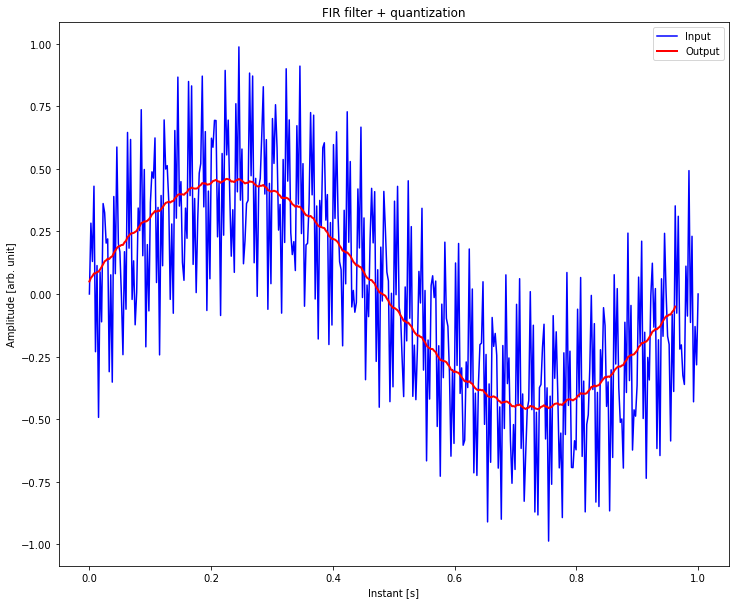

In [60]:
#The VHDL filter does not support float operations, so the input data and the coefficients must be converted to integers
#Before doing so, they are scaled to limit the loss of precision:

SCALING = 4e4
input_data = (input_signal * SCALING).astype(np.int32)
vhdl_coeff = (coefficients * SCALING).astype(np.int32)

#With DATA_WIDTH = 32, the FIR can output 32 bit signed numbers, ranging from -2147483648 to 2147483647
#Since both the input and the coefficients get scaled, the final result is scaled by SCALING**2
#So, approximately, the maximum SCALING allowed is sqrt(2147483647) = 46340

#Save data to files
np.savetxt("input_vectors.txt", input_data, fmt='%d')
np.savetxt("fir_taps.txt", vhdl_coeff, fmt='%d')

#Taking into account the lost precision, the final result is the following
filtered_out = np.convolve(input_data, vhdl_coeff, mode='valid')

#Save to a file for the comparison
np.savetxt("output_expected.txt", filtered_out, fmt='%d')

plt.figure(figsize=(12,10))
plt.plot(xs, input_data / SCALING, label='Input', c='b')
plt.plot(xs[0:len(filtered_out)], filtered_out / (SCALING**2), c='r', lw=2, label='Output')
#plt.plot(xs[0:len(filtered_signal)], filtered_signal,'--', c='k',  lw=2, label='Output') #Original output
plt.title("FIR filter + quantization")
plt.xlabel("Instant [s]")
plt.ylabel("Amplitude [arb. unit]")
plt.legend()
plt.show()


In [66]:
#Code for exporting plot to Latex
textwidth = 483.69687 #pt

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

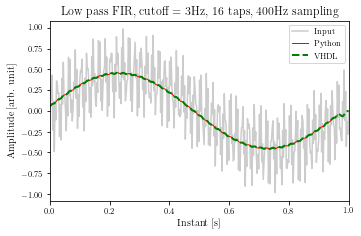

In [69]:
o_vhd = np.loadtxt("output_results.txt") #Load results from VHDL simulation

fig, ax = plt.subplots(1, 1, figsize=set_size(textwidth, fraction=.8))
ax.plot(xs, input_signal, c='gray', label='Input', alpha=.4)
ax.plot(xs[0:len(filtered_signal)], filtered_signal, c='r', lw=1, label='Python') #Python (without quantization)
ax.plot(xs, o_vhd[0:len(xs)] / SCALING**2,'--' ,c='green', label='VHDL', lw=2) #VHDL
ax.set_xlim(0, 1)
ax.set_xlabel("Instant [s]")
ax.set_ylabel("Amplitude [arb. unit]")
ax.set_title("Low pass FIR, cutoff = 3Hz, 16 taps, 400Hz sampling")
plt.legend()
plt.show()

fig.savefig('python_comparison.pdf', format='pdf', bbox_inches='tight')

#The VHDL curve continues, because the input_data is padded with zeros at the end